# Exploring Wine Classification with K-Nearest Neighbors: A Comprehensive Analysis
-------------------------------------------------------------------------------------------------------------------------------
#### AP21110010200 - Uday Sai Chaganti
#### AP21110010219 -  Sai Rohith 
#### AP21110010228 - Jithin Atluri
#### AP21110010253 - Chaitanya Sai
#### AP21110010260 -  Ritesh Jadhav
-------------------------------------------------------------------------------------------------------------------------------
# Problem Statement
In the context of wine production, it's crucial to ensure the quality of the final product. Chemical composition plays a significant role in determining the characteristics and quality of wine. The problem at hand is to develop a classification model that can accurately identify the origin of a wine sample based on its chemical composition. 


# Allll the Imports Used Throughout the Project

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statistics

from sklearn import datasets

from scipy.stats import norm

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

# Machine Learning Model
from sklearn.neighbors import KNeighborsClassifier

# Data normalization
from sklearn.preprocessing import MinMaxScaler

# Data standardization
from sklearn.preprocessing import StandardScaler

# Data dimensionality reduction
from sklearn.decomposition import PCA

# Splitting data for training and testing the model
from sklearn.model_selection import train_test_split

# Model accuracy evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Parameter optimization
from sklearn.model_selection import GridSearchCV


# Functions

### Plot Triangule Correlation Heatmap

In [2]:
def plot_triangle_correlation_heatmap(data):

    # Compute the correlation matrix
    corr = data.corr()

    # Create a boolean mask to display only the lower triangular part of the heatmap
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set the visual style of the plot to 'white'
    sns.set_theme(style="white")

    # Set the size of the plot and create the heatmap using seaborn
    plt.figure(figsize=(16, 6))
    heatmap = sns.heatmap(corr,
                          mask=mask,
                          cmap="rocket_r",
                          annot=True,
                          fmt=".2f",
                          linewidths=.5)

    # Set the title for the heatmap
    heatmap.set_title("Triangle Correlation Heatmap", pad=16)

    # Display the heatmap
    plt.show()

# Pre-Processing
## Feature Selection

### Plot Coefficient Magnitude Comparison

In [3]:
def plot_coefficient_magnitude_comparison(features_to_compare, data):

    plt.figure(figsize=(10, 6))

    markers = ['o', 's', '^', 'v', '<', '>', 'p', '*']

    for i, feature in enumerate(features_to_compare):
        marker = markers[i % len(markers)]
        plt.plot(data[feature], marker, label=feature)

    # Add a legend to the plot for feature identification
    plt.legend(loc='best')

    plt.ylabel('Coefficient Magnitude')
    plt.xlabel('Coefficient Index')

    plt.title('Comparison of Coefficient Magnitudes for Features')

    plt.show()

### Find and Analyze Outliers

In [4]:
def find_and_analyze_outliers(data):
             
    numeric_columns = data.select_dtypes(include=['float64', 'int64'])

    # Calculate the first quartile (Q1), third quartile (Q3), and interquartile range (IQR)
    Q1 = numeric_columns.quantile(0.25)
    Q3 = numeric_columns.quantile(0.75)
    IQR = Q3 - Q1

    # Define lower and upper bounds for outliers detection using IQR method
    inf_lim = Q1 - 1.5 * IQR
    sup_lim = Q3 + 1.5 * IQR

    # Identify outliers using lower and upper bounds
    outliers = ((numeric_columns < inf_lim) | (numeric_columns > sup_lim))

    # Count the number of outliers and calculate the percentage of outliers in each column
    outliers_count = outliers.sum()
    outliers_percentage = (outliers.sum() / len(numeric_columns)) * 100

    # Extract rows with any outlier in at least one numeric column
    df_outliers = data[outliers.any(axis=1)]

    # Create a DataFrame summarizing outlier count and percentage
    df_outliers_analyze = pd.DataFrame({
        'Outliers Count': outliers_count,
        'Outliers Percentage': outliers_percentage,
    })

    # Filter rows with non-zero outlier counts
    df_outliers_analyze = df_outliers_analyze[df_outliers_analyze['Outliers Count'] > 0]

    df_outliers_analyze = df_outliers_analyze.sort_values(by='Outliers Count', ascending=False)

    return df_outliers, df_outliers_analyze


### ANOVA F-value

alcohol: 135.07762424283948
malic_acid: 36.94342496318376
ash: 13.312901199989989
alcalinity_of_ash: 35.77163740730817
magnesium: 12.429584338150178
total_phenols: 93.73300962036775
flavanoids: 233.92587268154838
nonflavanoid_phenols: 27.575417146965727
proanthocyanins: 30.27138317022791
color_intensity: 120.66401844100372
hue: 101.31679539029965
od280/od315_of_diluted_wines: 189.97232057888206
proline: 207.92037390217828


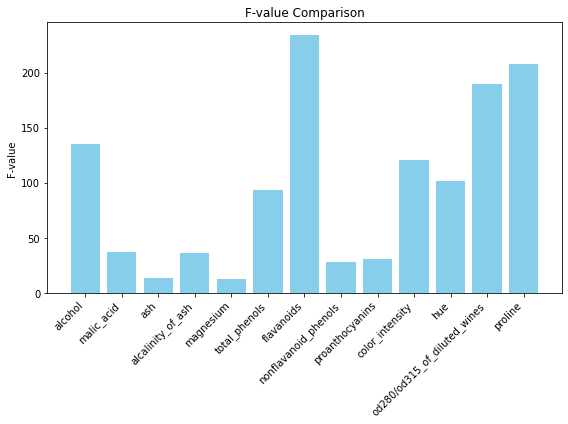

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.feature_selection import f_classif

wine = load_wine()
X_data = pd.DataFrame(wine.data, columns=wine.feature_names)
y_data = wine.target
feature_names = X_data.columns

f_value = f_classif(X_data, y_data)

for feature, f_val in zip(feature_names, f_value[0]):
    print(f"{feature}: {f_val}")

plt.figure(figsize=(8, 6))
plt.bar(x=feature_names, height=f_value[0], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('F-value')
plt.title('F-value Comparison')
plt.tight_layout()
plt.show()


### Plot Normal Distribution Comparison


In [6]:
def plot_normal_distribution_comparison(data, target=''):

    plt.figure(figsize=(15, 15))

    num_rows = 4 
    num_cols = 4  

    for i, column in enumerate(data.drop(columns=target).columns):
        plt.subplot(num_rows, num_cols, i + 1)

        plt.hist(data[column], bins=30, density=True, alpha=0.6, color='g')

        column_mean = np.mean(data[column])
        column_std = np.std(data[column])

        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, column_mean, column_std)
        plt.plot(x, p, 'k', linewidth=2)

        plt.title(f"Normal Distribution Plot for {column}")
        plt.xlabel(f"{column}")

    plt.tight_layout()

    plt.show()

# Machine Learning Model (KNN)

### Train and Evaluate KNN Model

In [7]:
def train_and_evaluate_knn_model(scale_name, X, y, n_neighbors=3, random_state=37):
    
    # Initialize k-Nearest Neighbors classifier with specified number of neighbors
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    # Split the data into training and test sets using random_state for reproducibility
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)
    
    # Train the model using the training data
    knn.fit(X_train, y_train)
    
    # Predictions and accuracy calculation for the training set
    y_prediction_train = knn.predict(X_train)
    y_accuracy_train = accuracy_score(y_train, y_prediction_train)
    
    # Predictions and accuracy calculation for the test set
    y_prediction_test = knn.predict(X_test)
    y_accuracy_test = accuracy_score(y_test, y_prediction_test)
    
    # Store model evaluation metrics in a DataFrame called 'model_scores'
    model_scores.loc[len(model_scores)] = [scale_name, y_accuracy_train, y_accuracy_test]
     
    print('----------------------------------')
    print(f'Train Confusion Matrix | {scale_name}')
    print('----------------------------------')
    print(pd.crosstab(y_train, y_prediction_train, rownames=['Real'], colnames=['Prediction'], margins=True))
    print('----------------------------------')
    print(f'Train Score: {y_accuracy_train}', end='\n\n')

    print('----------------------------------')
    print(f'Test Confusion Matrix | {scale_name}')
    print('----------------------------------')
    print(pd.crosstab(y_test, y_prediction_test, rownames=['Real'], colnames=['Prediction'], margins=True))
    print(f'Test Score: {y_accuracy_test}', end='\n\n')

    print('--------------------------------------------------------------------')
    print(f'Test Classification Metrics | {scale_name}')
    print('--------------------------------------------------------------------')
    print(classification_report(y_test, y_prediction_test, target_names=wine.target_names))


### Plot KNN Decision Regions

In [8]:
def plot_knn_decision_regions(X, y, n_neighbors, scale_name, labels=['X', 'Y']):
    
    # Initialize k-Nearest Neighbors classifier with specified number of neighbors
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)

    # Train the k-Nearest Neighbors classifier with the provided data
    knn.fit(X, y)

    # Create a figure for plotting decision regions
    plt.figure(figsize=(8, 5))

    # Plot decision regions using the mlxtend library function plot_decision_regions
    plot_decision_regions(X, y, clf=knn, legend=2)

    # Set X and Y axis labels based on the provided 'labels' list
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])

    # Set the title of the plot based on the provided 'scale_name'
    plt.title(f'DataFrame {scale_name} - KNN')

    # Display the plot
    plt.show()


# Dataset

In [9]:
df_wine = pd.read_csv('C:\\Users\\Nutakki\\Desktop\\wine\\winedata.csv')


In [10]:
data = pd.DataFrame(data=wine["data"],
                       columns= wine["feature_names"])

In [11]:
data["class"] = wine["target"]

In [12]:
df_wine = data.copy()

### Dataset Description

In [13]:
df_wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


### Data Dimension and Data Types

In [14]:
print(f'Number of Labels: {df_wine.shape[0]}')
print(f'Number of Features: {df_wine.shape[1]}')

Number of Labels: 178
Number of Features: 14


In [15]:
df_wine.dtypes

alcohol                         float64
malic_acid                      float64
ash                             float64
alcalinity_of_ash               float64
magnesium                       float64
total_phenols                   float64
flavanoids                      float64
nonflavanoid_phenols            float64
proanthocyanins                 float64
color_intensity                 float64
hue                             float64
od280/od315_of_diluted_wines    float64
proline                         float64
class                             int32
dtype: object

In [16]:
df_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  class

### Data Descriptive



In [17]:
# Select numeric attributes from the 'df_wine' DataFrame
numeric_attributes = df_wine.select_dtypes(include=['int64', 'float64'])

# Calculate mean and median for the numeric attributes
df_mean = pd.DataFrame(numeric_attributes.apply(np.mean)).T
df_median = pd.DataFrame(numeric_attributes.apply(np.median)).T

# Calculate dispersion statistics: std, min, max, range, skew, kurtosis
df_std = pd.DataFrame(numeric_attributes.apply(np.std)).T
df_min = pd.DataFrame(numeric_attributes.apply(min)).T
df_max = pd.DataFrame(numeric_attributes.apply(max)).T
df_range = pd.DataFrame(numeric_attributes.apply(lambda x: x.max() - x.min())).T
df_skew = pd.DataFrame(numeric_attributes.apply(lambda x: x.skew())).T
df_kurtosis = pd.DataFrame(numeric_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate the calculated statistics into a single DataFrame
df_descriptive = pd.concat([df_min, 
                            df_max,
                            df_range, 
                            df_mean,
                            df_median, 
                            df_std,
                            df_skew, 
                            df_kurtosis]).T.reset_index()

df_descriptive.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

# Display the resulting DataFrame 'm' with statistics for the numeric attributes
df_descriptive

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,alcohol,11.03,14.83,3.80,13.000618,13.050,0.809543,-0.051482,-0.852500
1,malic_acid,0.74,5.80,5.06,2.336348,1.865,1.114004,1.039651,0.299207
2,ash,1.36,3.23,1.87,2.366517,2.360,0.273572,-0.176699,1.143978
3,alcalinity_of_ash,10.60,30.00,19.40,19.494944,19.500,3.330170,0.213047,0.487942
4,magnesium,70.00,162.00,92.00,99.741573,98.000,14.242308,1.098191,2.104991
5,total_phenols,0.98,3.88,2.90,2.295112,2.355,0.624091,0.086639,-0.835627
6,flavanoids,0.34,5.08,4.74,2.029270,2.135,0.996049,0.025344,-0.880382
7,nonflavanoid_phenols,0.13,0.66,0.53,0.361854,0.340,0.124103,0.450151,-0.637191
8,proanthocyanins,0.41,3.58,3.17,1.590899,1.555,0.570749,0.517137,0.554649
9,color_intensity,1.28,13.00,11.72,5.058090,4.690,2.311765,0.868585,0.381522


In [18]:
df_wine.describe(include="all")

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


In [19]:
df_wine.isna().sum()

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
class                           0
dtype: int64

In [20]:
df_wine.duplicated().any()

False

In [21]:
df_wine.apply(lambda x: len(x.unique()))

alcohol                         126
malic_acid                      133
ash                              79
alcalinity_of_ash                63
magnesium                        53
total_phenols                    97
flavanoids                      132
nonflavanoid_phenols             39
proanthocyanins                 101
color_intensity                 132
hue                              78
od280/od315_of_diluted_wines    122
proline                         121
class                             3
dtype: int64

In [22]:
df_wine['class'].value_counts()

1    71
0    59
2    48
Name: class, dtype: int64

## Features values count

In [23]:
for feature in df_wine.columns:
    print('-------------------------')
    print(f'Series: {feature}')
    print('-------------------------')
    print(f'{df_wine[feature].value_counts()}\n')
    

-------------------------
Series: alcohol
-------------------------
13.05    6
12.37    6
12.08    5
12.29    4
12.42    3
        ..
13.72    1
13.29    1
13.74    1
13.77    1
14.13    1
Name: alcohol, Length: 126, dtype: int64

-------------------------
Series: malic_acid
-------------------------
1.73    7
1.67    4
1.81    4
1.68    3
1.61    3
       ..
1.09    1
1.19    1
1.17    1
1.01    1
4.10    1
Name: malic_acid, Length: 133, dtype: int64

-------------------------
Series: ash
-------------------------
2.30    7
2.28    7
2.70    6
2.32    6
2.36    6
       ..
2.16    1
2.53    1
1.75    1
1.71    1
2.37    1
Name: ash, Length: 79, dtype: int64

-------------------------
Series: alcalinity_of_ash
-------------------------
20.0    15
16.0    11
21.0    11
18.0    10
19.0     9
        ..
12.4     1
17.1     1
16.4     1
16.3     1
27.0     1
Name: alcalinity_of_ash, Length: 63, dtype: int64

-------------------------
Series: magnesium
-------------------------
88.0     13


### Check Normal Distribution

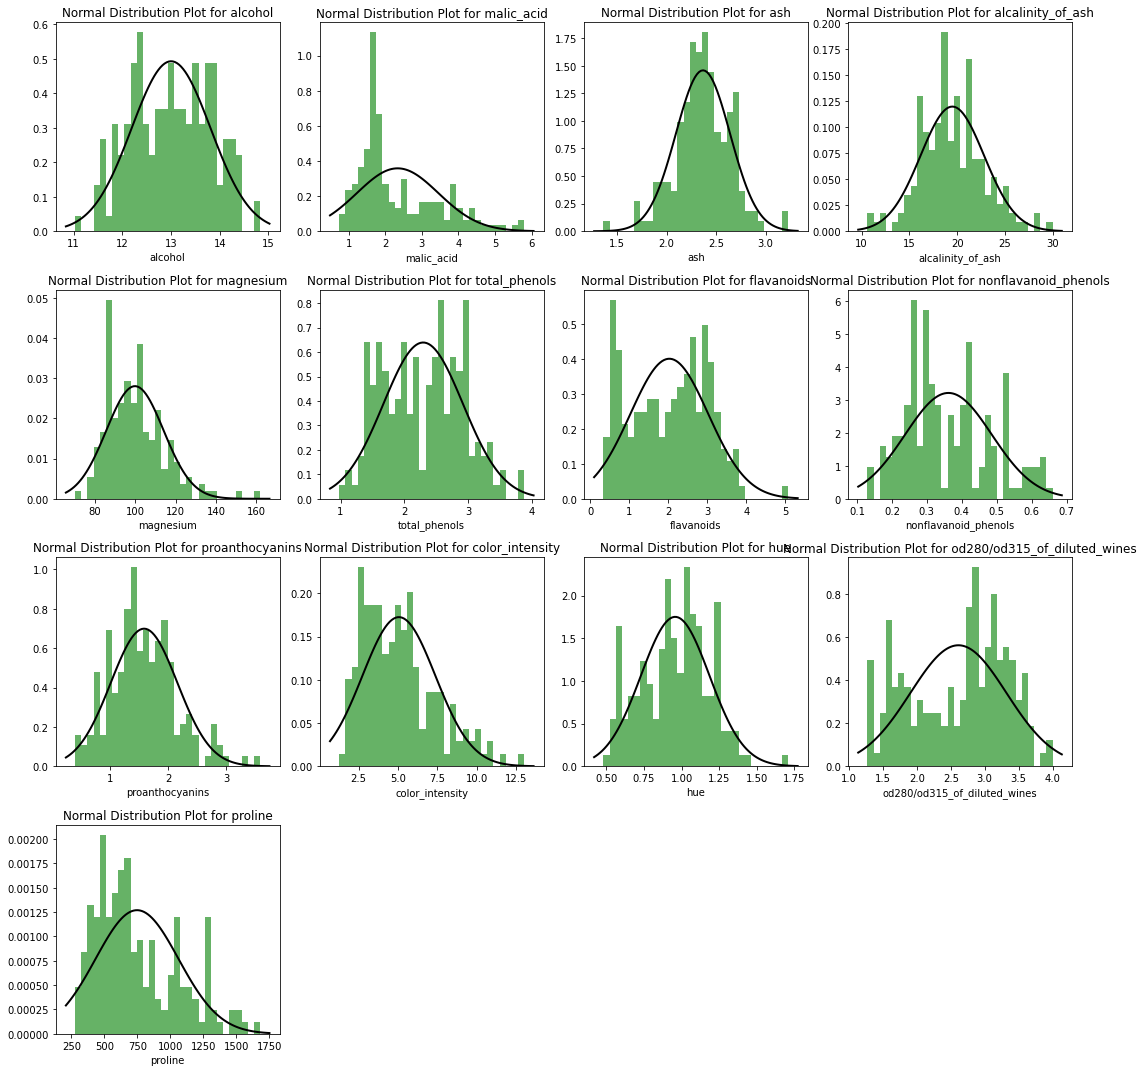

In [24]:
plot_normal_distribution_comparison(df_wine, 'class')

## Check Correlation

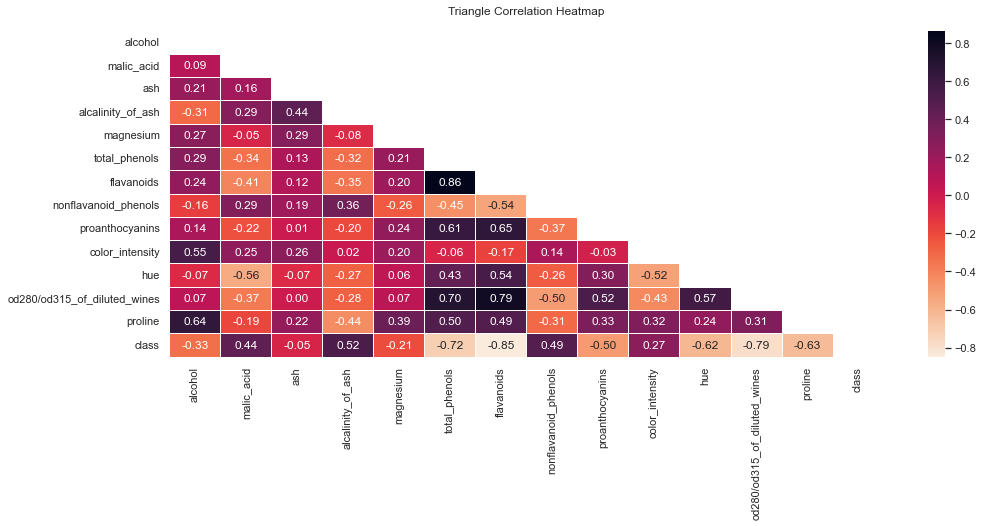

In [25]:
plot_triangle_correlation_heatmap(df_wine)

## Comparing the coefficients of magnitude of the highest correlations


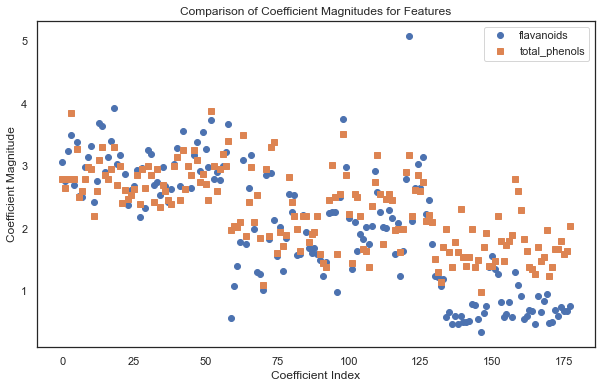

In [26]:
features_to_compare = ['flavanoids', 'total_phenols']

plot_coefficient_magnitude_comparison(features_to_compare, df_wine)

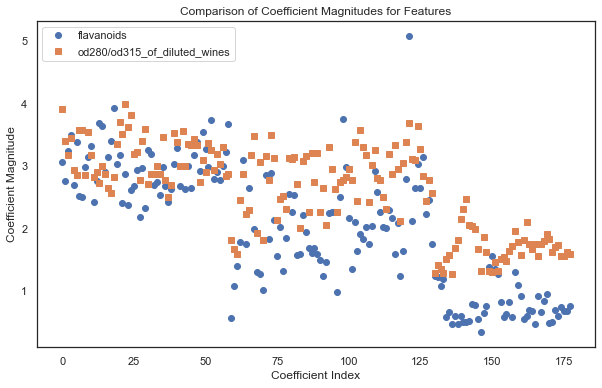

In [27]:
features_to_compare = ['flavanoids', 'od280/od315_of_diluted_wines']

plot_coefficient_magnitude_comparison(features_to_compare, df_wine)

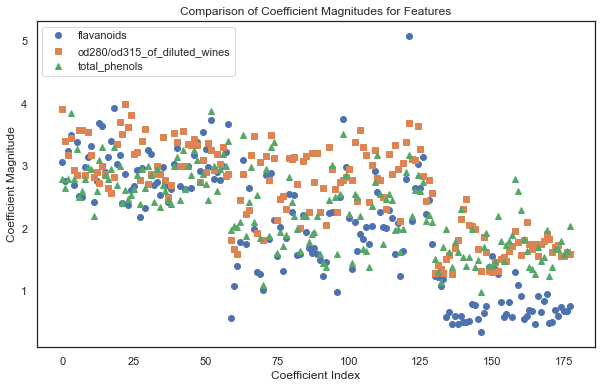

In [28]:
features_to_compare = ['flavanoids', 'od280/od315_of_diluted_wines', 'total_phenols']

plot_coefficient_magnitude_comparison(features_to_compare, df_wine)

## Outliers 

In [29]:
df_outliers, df_outliers_analyze = find_and_analyze_outliers(df_wine)

In [30]:
df_outliers_analyze

,Outliers Count,Outliers Percentage
alcalinity_of_ash,4,2.247191
magnesium,4,2.247191
color_intensity,4,2.247191
malic_acid,3,1.685393
ash,3,1.685393
proanthocyanins,2,1.123596
hue,1,0.561798


In [31]:
df_outliers

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
25,13.05,2.05,3.22,25.0,124.0,2.63,2.68,0.47,1.92,3.58,1.13,3.20,830.0,0
59,12.37,0.94,1.36,10.6,88.0,1.98,0.57,0.28,0.42,1.95,1.05,1.82,520.0,1
69,12.21,1.19,1.75,16.8,151.0,1.85,1.28,0.14,2.50,2.85,1.28,3.07,718.0,1
73,12.99,1.67,2.60,30.0,139.0,3.30,2.89,0.21,1.96,3.35,1.31,3.50,985.0,1
78,12.33,0.99,1.95,14.8,136.0,1.90,1.85,0.35,2.76,3.40,1.06,2.31,750.0,1
95,12.47,1.52,2.20,19.0,162.0,2.50,2.27,0.32,3.28,2.60,1.16,2.63,937.0,1
110,11.46,3.74,1.82,19.5,107.0,3.18,2.58,0.24,3.58,2.90,0.75,2.81,562.0,1
115,11.03,1.51,2.20,21.5,85.0,2.46,2.17,0.52,2.01,1.90,1.71,2.87,407.0,1
121,11.56,2.05,3.23,28.5,119.0,3.18,5.08,0.47,1.87,6.00,0.93,3.69,465.0,1
123,13.05,5.80,2.13,21.5,86.0,2.62,2.65,0.30,2.01,2.60,0.73,3.10,380.0,1


# Transformation and Cleaning 


In [32]:
df_wine_without_outliers = df_wine.copy()

In [33]:
df_wine_without_outliers.drop(labels= df_outliers.index, inplace = True)

In [34]:
df_wine_without_outliers.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [35]:
df_wine_without_outliers.shape

(161, 14)

## Normalization

In [36]:
df_wine_without_outliers.drop(columns='class')

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,14.16,2.51,2.48,20.0,91.0,1.68,0.70,0.44,1.24,9.70,0.62,1.71,660.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


In [37]:
normalized_obj = MinMaxScaler().fit(df_wine_without_outliers.drop(columns='class'))

In [38]:
normalized_obj = normalized_obj.transform(df_wine_without_outliers.drop(columns='class'))

In [39]:
normalized_obj

array([[0.8245614 , 0.21797753, 0.59836066, ..., 0.54945055, 0.97069597,
        0.56134094],
       [0.52339181, 0.23370787, 0.36065574, ..., 0.56043956, 0.78021978,
        0.55064194],
       [0.51169591, 0.36404494, 0.79508197, ..., 0.53846154, 0.6959707 ,
        0.64693295],
       ...,
       [0.54385965, 0.79550562, 0.45901639, ..., 0.05494505, 0.10622711,
        0.39728959],
       [0.51461988, 0.41573034, 0.54918033, ..., 0.06593407, 0.12820513,
        0.40085592],
       [0.79532164, 0.75505618, 0.85245902, ..., 0.07692308, 0.12087912,
        0.20114123]])

In [40]:
df_wine_normalized = pd.DataFrame(normalized_obj, columns=df_wine_without_outliers.drop(columns='class').columns)

In [41]:
df_wine_normalized.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,0.824561,0.217978,0.598361,0.278481,0.890625,0.627586,0.757660,0.283019,0.737255,0.471861,0.549451,0.970696,0.561341
1,0.523392,0.233708,0.360656,0.000000,0.468750,0.575862,0.674095,0.245283,0.341176,0.335498,0.560440,0.780220,0.550642
2,0.511696,0.364045,0.795082,0.468354,0.484375,0.627586,0.807799,0.320755,0.941176,0.476190,0.538462,0.695971,0.646933
3,0.865497,0.271910,0.655738,0.354430,0.671875,0.989655,0.877437,0.207547,0.694118,0.705628,0.351648,0.798535,0.857347
4,0.535088,0.415730,0.959016,0.620253,0.750000,0.627586,0.654596,0.490566,0.552941,0.329004,0.549451,0.608059,0.325963


## Standardization

In [42]:
standardized_obj = StandardScaler().fit(df_wine_without_outliers.drop(columns='class'))

In [43]:
standardized_obj = standardized_obj.transform(df_wine_without_outliers.drop(columns='class'))

In [44]:
standardized_obj

array([[ 1.49571092, -0.57112999,  0.27742496, ...,  0.37214873,
         1.82667765,  0.94743557],
       [ 0.20069843, -0.50414451, -0.92862453, ...,  0.41815299,
         1.09101548,  0.90097568],
       [ 0.15040669,  0.05087806,  1.27553489, ...,  0.32614447,
         0.76562644,  1.31911473],
       ...,
       [ 0.28870899,  1.88819414, -0.42956957, ..., -1.69804288,
        -1.51209683,  0.23505052],
       [ 0.16297962,  0.27097322,  0.02789748, ..., -1.65203863,
        -1.42721274,  0.25053715],
       [ 1.36998156,  1.71594576,  1.56665028, ..., -1.60603437,
        -1.45550744, -0.61671423]])

In [45]:
df_wine_standardized = pd.DataFrame(standardized_obj, columns = df_wine_without_outliers.drop(columns='class').columns)

In [46]:
df_wine_standardized

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,1.495711,-0.571130,0.277425,-1.208619,2.309259,0.808420,1.034224,-0.643463,1.415284,0.296494,0.372149,1.826678,0.947436
1,0.200698,-0.504145,-0.928625,-2.672685,0.118914,0.570475,0.728906,-0.808165,-0.511374,-0.300438,0.418153,1.091015,0.900976
2,0.150407,0.050878,1.275535,-0.210392,0.200038,0.808420,1.217414,-0.478761,2.407227,0.315445,0.326144,0.765626,1.319115
3,1.671732,-0.341465,0.568540,-0.809329,1.173525,2.474030,1.471845,-0.972867,1.205450,1.319806,-0.455928,1.161752,2.232826
4,0.250990,0.270973,2.107293,0.588189,1.579144,0.808420,0.657665,0.262398,0.518720,-0.328863,0.372149,0.426090,-0.074682
...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,1.407700,0.194418,0.485365,0.255447,-0.611200,-0.968231,-1.367607,0.674153,-0.587678,2.219942,-1.560030,-1.299887,-0.306982
157,0.452157,1.534128,0.485365,1.253674,0.281162,-0.777876,-1.316721,0.591802,-0.263389,1.082929,-1.191996,-1.512097,-0.028222
158,0.288709,1.888194,-0.429570,0.255447,1.741392,-1.110998,-1.377785,0.591802,-0.377843,2.456820,-1.698043,-1.512097,0.235051
159,0.162980,0.270973,0.027897,0.255447,1.741392,-1.015820,-1.387962,1.415312,-0.168009,2.030440,-1.652039,-1.427213,0.250537


# Defining Input Data

In [47]:
df_target = df_wine_without_outliers["class"]

In [48]:
df_normalized = df_wine_normalized

In [49]:
df_standardized = df_wine_standardized

# Model (KNN)

## Accuracy List

In [50]:
model_scores = pd.DataFrame(columns=['Scale', 'Train Score', 'Test Score'])

## Normalized

In [51]:
train_and_evaluate_knn_model("Normalized", df_normalized, df_target)

----------------------------------
Train Confusion Matrix | Normalized
----------------------------------
Prediction   0   1   2  All
Real                       
0           44   0   0   44
1            2  42   2   46
2            0   0  30   30
All         46  42  32  120
----------------------------------
Train Score: 0.9666666666666667

----------------------------------
Test Confusion Matrix | Normalized
----------------------------------
Prediction   0   1   2  All
Real                       
0           14   0   0   14
1            0  15   0   15
2            0   0  12   12
All         14  15  12   41
Test Score: 1.0

--------------------------------------------------------------------
Test Classification Metrics | Normalized
--------------------------------------------------------------------
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        14
     class_1       1.00      1.00      1.00        15
     class_2       1.00   

## Standardized

In [52]:
train_and_evaluate_knn_model('Standardized',df_standardized, df_target)

----------------------------------
Train Confusion Matrix | Standardized
----------------------------------
Prediction   0   1   2  All
Real                       
0           44   0   0   44
1            2  41   3   46
2            0   0  30   30
All         46  41  33  120
----------------------------------
Train Score: 0.9583333333333334

----------------------------------
Test Confusion Matrix | Standardized
----------------------------------
Prediction   0   1   2  All
Real                       
0           14   0   0   14
1            0  15   0   15
2            0   1  11   12
All         14  16  11   41
Test Score: 0.975609756097561

--------------------------------------------------------------------
Test Classification Metrics | Standardized
--------------------------------------------------------------------
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        14
     class_1       0.94      1.00      0.97        15
     c

## Summary

In [53]:
model_scores

,Scale,Train Score,Test Score
0,Normalized,0.966667,1.00000
1,Standardized,0.958333,0.97561


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def train_and_evaluate_random_forest(scale_name, X, y, n_estimators=100, random_state=37):
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)
    

    rf.fit(X_train, y_train)
    

    y_pred = rf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    print(f'Accuracy of Random Forest classifier ({scale_name}): {accuracy:.2f}')


X = df_wine.drop(columns=['class'])
y = df_wine['class']

train_and_evaluate_random_forest('Original', X, y)
